In [349]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [350]:
#Parameters
trading_window = 15

#MACD parameters
n = 9
m = 19
t = 6

#RSI parameters
period = 14

In [351]:
dataimport=pd.read_csv('/Users/vedantgupta/Documents/project /summer project(finance)/data-analysis-with-technical-indicators-2/Pair Trading final/data/Indexes/SP GLOBAL 100.csv')
datacopy1 = dataimport.copy()
dataimport['Date'] = pd.to_datetime(dataimport['Date'])
curr = dataimport.columns[0]
dataimport.rename(columns={curr: 'Stocks'}, inplace=True)
dataimport.set_index('Stocks', inplace=True)

#data = dataimport.resample('M').first()  #Monthly Resampling



#dataimport.head()

In [352]:

def first_last_diff(x):
    return ((x.iloc[-1] - x.iloc[0])/x.iloc[0])
monthly = dataimport[dataimport.columns].resample('W').agg(first_last_diff)
#monthly.head()

In [353]:
data = dataimport.transpose()
#data.head()

In [354]:
train_data = monthly.iloc[:48]  

for i in train_data.columns:
    train_data[i] = (1 + train_data[i]).cumprod() - 1

train_data=train_data.transpose()
#train_data

/var/folders/90/5g2l2f2j191dmr85qjr8jrn40000gn/T/ipykernel_61352/1478826489.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[i] = (1 + train_data[i]).cumprod() - 1


In [355]:
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation()
ap.fit(train_data)
labels = ap.predict(train_data)

In [356]:
groups = []
for i in range(labels.max()+1):
    arr = []
    for j in range(len(labels)):
        if labels[j] == i:
            arr.append(train_data.index[j])
    groups.append(arr)


for i in range(len(groups)):
    print("Group", i+1, ":", groups[i])

Group 1 : ['BBVA SQ Equity', 'SAN SQ Equity', '700 HK Equity', 'ALV GY Equity', 'DBK GY Equity', 'PRU LN Equity']
Group 2 : ['RIO LN Equity', 'AAL LN Equity', 'JPM UN Equity', 'GE UN Equity', '7267 JT Equity', 'MMM UN Equity', 'MSFT UW Equity', 'BHP AT Equity', 'EMR UN Equity', 'BAYN GY Equity', 'DD UN Equity']
Group 3 : ['NVDA UW Equity']
Group 4 : ['CAT UN Equity', 'TEF SQ Equity', 'TTE FP Equity', 'PFE UN Equity', 'RTX UN Equity', 'JCI UN Equity', 'ABBN SE Equity', 'SREN SE Equity', 'UBSG SE Equity', 'HSBA LN Equity', 'AON UN Equity', 'BARC LN Equity', 'SU FP Equity', 'BAS GY Equity', 'DTE GY Equity', '7203 JT Equity']
Group 5 : ['CS FP Equity', 'INGA NA Equity']
Group 6 : ['KO UN Equity', 'MCD UN Equity', 'INTC UW Equity', 'MC FP Equity', 'ABT UN Equity', 'TMO UN Equity', 'ULVR LN Equity', 'GSK LN Equity', 'AZN LN Equity', 'CL UN Equity', 'KMB UN Equity', 'LLY UN Equity']
Group 7 : ['CVX UN Equity', 'AMT UN Equity', 'AMZN UW Equity', 'IBM UN Equity', 'SGO FP Equity', '5108 JT Equit

# Indicators

In [357]:

datacopy1['Date'] = pd.to_datetime(datacopy1['Date'])
datacopy1.set_index('Date', inplace=True)
data = datacopy1.resample('W').first()  # Weekly Resampling

data.reset_index(inplace=True)
data['Date'] = data['Date'].astype(str)
stock_names = data.columns[1:]

datacopy = data.copy()

#data

In [358]:
def MACD(price_data, short_window, long_window, signal_window, column_name):
    data = price_data
   
    data.loc[:,'EMAn'] = data[column_name].ewm(span=short_window, adjust=False).mean()
    data.loc[:,'EMAm'] = data[column_name].ewm(span=long_window, adjust=False).mean()

    for i in range(short_window):
        data.loc[i,'EMAn'] = None
    for i in range(long_window):
        data.loc[i,'EMAm'] = None
    
    data['MACD'] = data['EMAn'] - data['EMAm']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    trade_sig=np.zeros([len(data),1],dtype=float)

    for i in range(long_window+1,len(data)):
        if data.loc[i,'MACD'] > data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] < data.loc[i-1,'Signal Line']:
            trade_sig[i] = 1
        if data.loc[i,'MACD'] < data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] > data.loc[i-1,'Signal Line']:
            trade_sig[i] = -1
        
    trade_sig=trade_sig.reshape(len(trade_sig),1)

    data_numpy=data['Date'].to_numpy()
    data_numpy=data_numpy.reshape(len(data_numpy),1)
    data_numpy=np.column_stack((data_numpy,data[column_name].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAn'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAm'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['MACD'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['Signal Line'].to_numpy()))

    final=np.column_stack((data_numpy,trade_sig))
    final_df=pd.DataFrame(final,columns=['Date','Close','EMAn','EMAm','MACD','Signal Line','Trade Signal'],index=data.index)

    final_df.drop(["EMAn","EMAm","MACD","Signal Line"],axis=1,inplace=True)
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    final_df['Close'] = final_df['Close'].astype(float) 
    final_df['Trade Signal'] = final_df['Trade Signal'].astype(int)

    return final_df


master_macd = pd.DataFrame()

for name in stock_names:
    temp = MACD(data, n, m, t, name)
    temp = temp[['Date','Trade Signal']]
    temp.columns = ['Date',name]
    temp.set_index('Date', inplace=True)
    master_macd = pd.concat([master_macd, temp], axis=1)

In [359]:
master_macd.insert(0, 'Date', master_macd.index)
master_macd.reset_index(drop=True, inplace=True)
master_macd = master_macd[period:]
master_macd = master_macd.reset_index(drop=True)
#master_macd = master_macd[232:725]
#master_macd

In [360]:
def calculate_rsi(prices, period):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def generate_signals(rsi_values):
    signals = np.zeros(rsi_values.shape)
    for rsi in rsi_values:
        if rsi < 30:
            signals[rsi_values == rsi] = 1
        elif rsi > 70:
            signals[rsi_values == rsi] = -1
    return signals

rsi_values = pd.DataFrame()
rsi_values['Date'] = data['Date']
for stock in stock_names:
    rsi_values[stock] = calculate_rsi(data[stock], period)

master_rsi = rsi_values[period:]

In [361]:
#master_rsi = master_rsi[232:725]
master_rsi = master_rsi.reset_index(drop=True)
#master_rsi

In [362]:
prices = datacopy
prices = prices[period:]
prices = prices.reset_index(drop=True)
#prices

#  strat1 RSI+MACD fixed exit strat

In [363]:
def get_returns(groups,master_macd,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_macd.iloc[i,j]==1):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_macd.iloc[i,j]==-1):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                intrade.append(l)
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                temp += (((b2-b1))*intrade[x][2]) + ((s1-s2))
                n += 1
            intrade = []
            returns.append(temp)
            num_trades.append(n)
            n = 0
            temp = 0

        i += 1

    return returns,num_trades

In [364]:
returns,num_trades = get_returns(groups,master_macd,master_rsi,prices,trading_window)

In [365]:
tradesheet1 = pd.DataFrame()
tradesheet1['Returns'] = returns
tradesheet1['Number of Trades'] = num_trades
windows = []
for i in range(len(returns)):
    windows.append(i+1)
tradesheet1.insert(0,f'Window (period = {trading_window})',windows)
tradesheet1

,Window (period = 15),Returns,Number of Trades
0,1,6.241777,8
1,2,-3.263931,10
2,3,-992.978364,8
3,4,66.789767,12
4,5,31.088964,9
5,6,-1093.135289,26
6,7,336.422011,22
7,8,57.294907,12
8,9,52.005601,14
9,10,48.898170,21


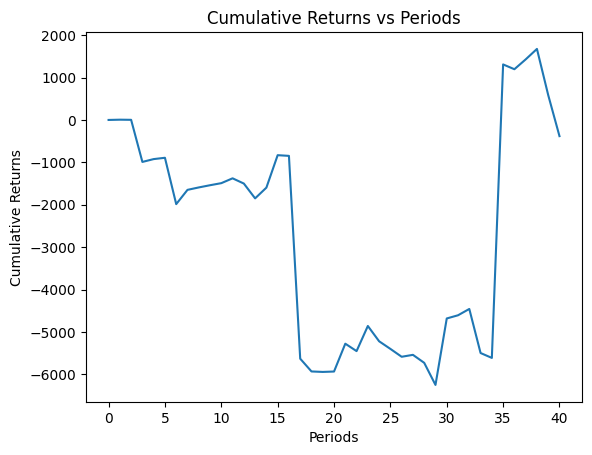

In [366]:
cumulative_returns_1 = []
cumulative_returns_1.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_1.append(s)


plt.plot(windows,cumulative_returns_1)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()


# Strat-2 with variable exit in window + fixed exit at the end

In [367]:
def get_returns_2(groups,master_macd,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_macd.iloc[i,j]==1):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_macd.iloc[i,j]==-1):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                intrade.append(l)
            
            elif(buy!=0):
                for trade in intrade:
                    if(trade[3]==buy):
                        b1 = prices.iloc[trade[0],trade[1]]
                        s1 = prices.iloc[trade[0],trade[3]]
                        b2 = prices.iloc[i,trade[1]]
                        s2 = prices.iloc[i,trade[3]]
                        temp += (((b2-b1))*trade[2]) + ((s1-s2))
                        intrade.remove(trade)
                        n += 1


            elif(sell!=0):
                for trade in intrade:
                    if(trade[1]==sell):
                        b1 = prices.iloc[trade[0],trade[1]]
                        s1 = prices.iloc[trade[0],trade[3]]
                        b2 = prices.iloc[i,trade[1]]
                        s2 = prices.iloc[i,trade[3]]
                        temp += (((b2-b1))*trade[2]) + ((s1-s2))
                        intrade.remove(trade)
                        n += 1 
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                temp += (((b2-b1))*intrade[x][2]) + ((s1-s2))
                n += 1
            intrade = []
            returns.append(temp)
            num_trades.append(n)
            temp = 0
            n = 0

        i += 1

    return returns,num_trades

In [368]:
returns,num_trades = get_returns_2(groups,master_macd,master_rsi,prices,trading_window)

In [369]:
tradesheet2 = pd.DataFrame()
tradesheet2['Returns'] = returns
tradesheet2['Number of Trades'] = num_trades
windows = []
for i in range(len(returns)):
    windows.append(i+1)
tradesheet2.insert(0,f'Window (period = {trading_window})',windows)
tradesheet2

,Window (period = 15),Returns,Number of Trades
0,1,6.241777,8
1,2,-4.256950,10
2,3,-990.899644,8
3,4,-17.414373,12
4,5,-55.796539,9
5,6,-824.061041,26
6,7,425.078172,22
7,8,61.366332,12
8,9,-12.084134,14
9,10,115.336752,21


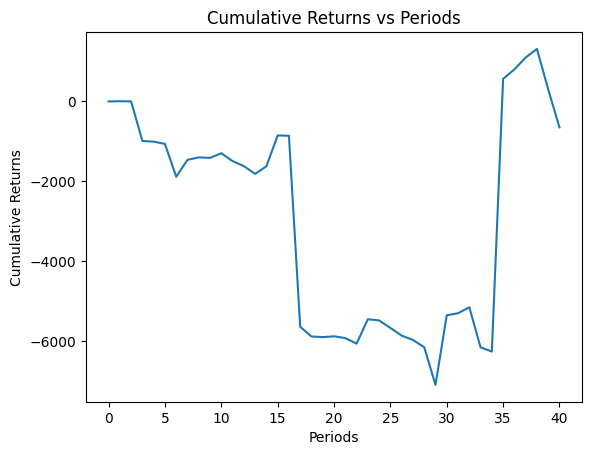

In [370]:

cumulative_returns_2 = []
cumulative_returns_2.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_2.append(s)


plt.plot(windows,cumulative_returns_2)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()


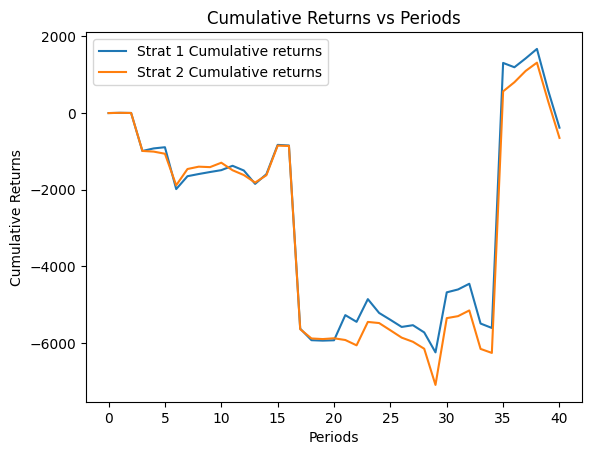

In [371]:
plt.plot(windows,cumulative_returns_1,label = "Strat 1 Cumulative returns")
plt.plot(windows,cumulative_returns_2,label = "Strat 2 Cumulative returns")
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.legend()
plt.savefig('/Users/vedantgupta/Documents/project /summer project(finance)/data-analysis-with-technical-indicators-2/Pair Trading final/plots/with clustering/weekly/SP GLOBAL 100_macd_rsi.png')
plt.show()

# strat 3 RSI Fixed exit

In [372]:
def get_returns(groups,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_rsi.iloc[i,j]<30):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_rsi.iloc[i,j]>70):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                intrade.append(l)
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                temp += (((b2-b1))*intrade[x][2]) + ((s1-s2))
                n+=1
            intrade = []
            returns.append(temp)
            temp = 0
            num_trades.append(n)
            n = 0

        i += 1

    return returns,num_trades

In [373]:
returns,num_trades = get_returns(groups,master_rsi,prices,trading_window)

In [374]:
tradesheet3 = pd.DataFrame()
tradesheet3['Returns'] = returns
tradesheet3['Number of Trades'] = num_trades
windows = []
for i in range(len(returns)):
    windows.append(i+1)
tradesheet3.insert(0,f'Window (period = {trading_window})',windows)
tradesheet3

,Window (period = 15),Returns,Number of Trades
0,1,50.181926,2
1,2,0.000000,0
2,3,0.000000,0
3,4,0.000000,1
4,5,-12.338218,2
5,6,217.444866,6
6,7,-49.872216,6
7,8,-73.341536,7
8,9,11.781128,3
9,10,0.000000,0


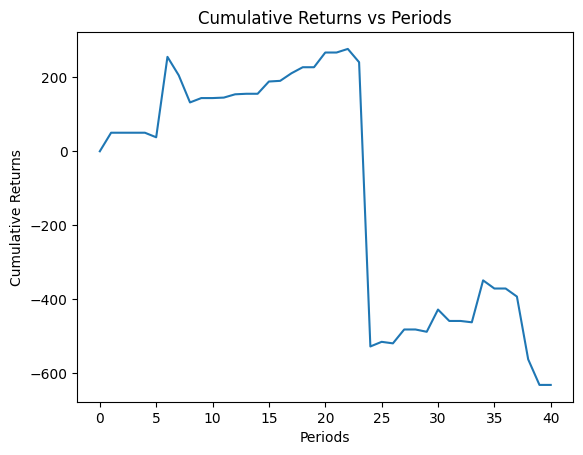

In [375]:
cumulative_returns_3 = []
cumulative_returns_3.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_3.append(s)


plt.plot(windows,cumulative_returns_3)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()

# strat 4 RSI variable exit

In [376]:
def get_returns(groups,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_rsi.iloc[i,j]<30):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_rsi.iloc[i,j]>70):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                intrade.append(l)
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                temp += (((b2-b1))*intrade[x][2]) + ((s1-s2))
                n+=1
            intrade = []
            returns.append(temp)
            temp = 0
            num_trades.append(n)
            n = 0

        i += 1

    return returns,num_trades

In [377]:
tradesheet4 = pd.DataFrame()
tradesheet4['Returns'] = returns
tradesheet4['Number of Trades'] = num_trades
windows = []
for i in range(len(returns)):
    windows.append(i+1)
tradesheet4.insert(0,f'Window (period = {trading_window})',windows)
tradesheet4

,Window (period = 15),Returns,Number of Trades
0,1,50.181926,2
1,2,0.000000,0
2,3,0.000000,0
3,4,0.000000,1
4,5,-12.338218,2
5,6,217.444866,6
6,7,-49.872216,6
7,8,-73.341536,7
8,9,11.781128,3
9,10,0.000000,0


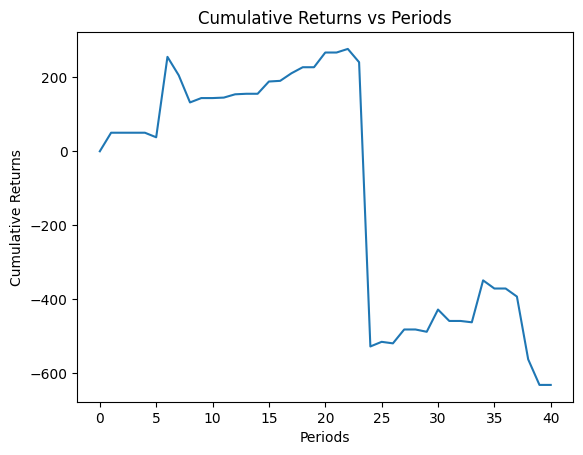

In [378]:
cumulative_returns_4 = []
cumulative_returns_4.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_4.append(s)


plt.plot(windows,cumulative_returns_4)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()

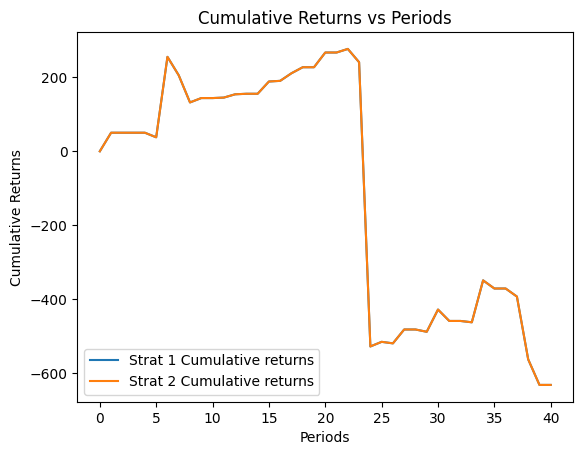

In [379]:
plt.plot(windows,cumulative_returns_3,label = "Strat 1 Cumulative returns")
plt.plot(windows,cumulative_returns_4,label = "Strat 2 Cumulative returns")
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.legend()
plt.savefig('/Users/vedantgupta/Documents/project /summer project(finance)/data-analysis-with-technical-indicators-2/Pair Trading final/plots/with clustering/weekly/SP GLOBAL 100_rsi.png')
plt.show()
